#### Principal Component Analysis
PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns components in its fit method, and can be used on new data to project it on these components.

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

explained variance ratio (first two components): [0.99809123 0.00173592]


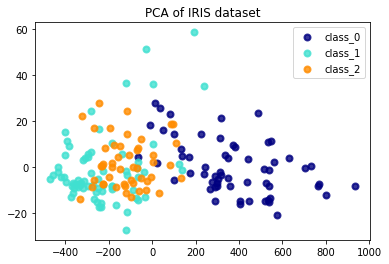

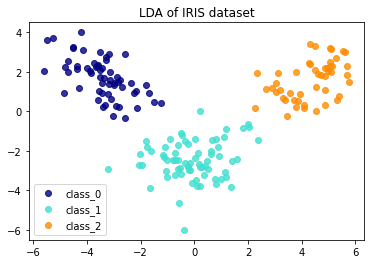

In [18]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

wine = datasets.load_wine() #load_wine()

X = wine.data
y = wine.target
target_names = wine.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

##### Model selection with probabilistic PCA and Factor Analysis
Probabilistic PCA and Factor Analysis are probabilistic models. The consequence is that the likelihood of new data can be used for model selection and covariance estimation. Here we compare PCA and FA with cross-validation on low rank data corrupted with homoscedastic noise (noise variance is the same for each feature) or heteroscedastic noise (noise variance is the different for each feature). In a second step we compare the model likelihood to the likelihoods obtained from shrinkage covariance estimators.

One can observe that with homoscedastic noise both FA and PCA succeed in recovering the size of the low rank subspace. The likelihood with PCA is higher than FA in this case. However PCA fails and overestimates the rank when heteroscedastic noise is present. Under appropriate circumstances the low rank models are more likely than shrinkage models.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [21]:
# Create the data
n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

In [22]:
# Fit the models
n_components = np.arange(0, n_features, 5)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
best n_components by PCA CV = 35
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 38


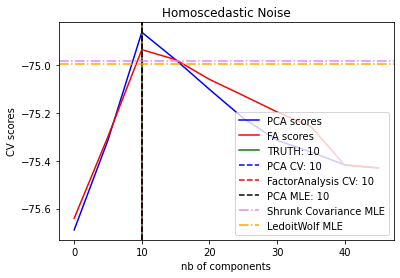

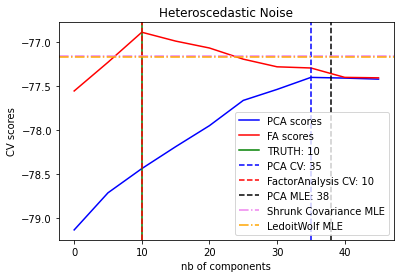

In [23]:
for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b', label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r', label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
    plt.axvline(n_components_pca_mle, color='k', label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet', label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange', label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()


#### Incremental PCA
Since PCA only does batch processing which means all the data must fit into memory, the IncrementalPCA object uses a different form of processing and allows for partial computations which almost exactly match the results of PCA while processing the data in a minibatch fashion.

#### PCA and Randomized SVD


In [26]:
# Faces recognition example using eigenfaces and SVMs
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

2021-02-20 23:08:10,867 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2021-02-20 23:08:12,126 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2021-02-20 23:08:13,313 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2021-02-20 23:08:14,527 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

In [27]:
# Split into a training set and a test set using a stratified k fold
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 1.610s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s


In [29]:
# Train a SVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 18.932s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [30]:
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.101s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       1.00      0.75      0.86        36

         accuracy                           0.85       322
        macro avg       0.90      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  7   1   0   5   0   0   0]
 [  1  52   2   5   0   0   0]
 [  0   3  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   4   0   3   1   7   0]
 [  0   2   1   6   0   0  27]]


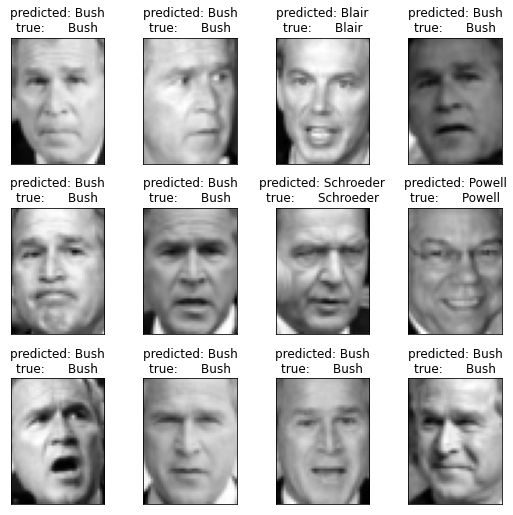

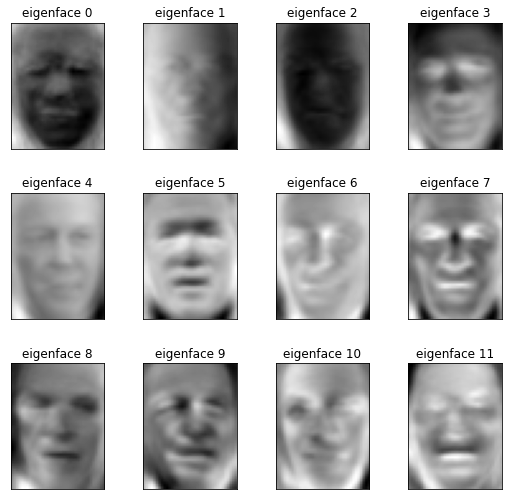

In [31]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/sod/scikit_learn_data
Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.500s
Extracting the top 6 Non-negative components - NMF...
done in 0.870s
Extracting the top 6 Independent components - FastICA...
done in 0.309s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.513s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.629s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.359s
Extracting the top 6 Factor Analysis components - FA...
done in 1.306s
Extracting the top 6 Dictionary learning...
done in 3.621s
Extracting the top 6 Dictionary learning - positive dictionary...
done in 3.214s
Extracting the top 6 Dictionary learning - positive code...
done in 1.415s
Extracting the top 6 Dictionary learning - positive dictionary & code...
done in 1.484s


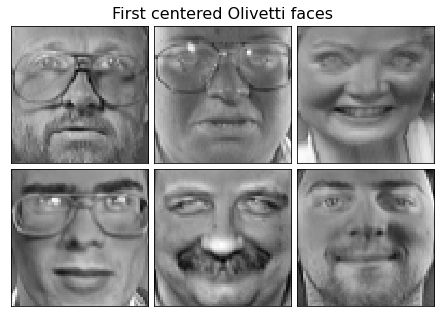

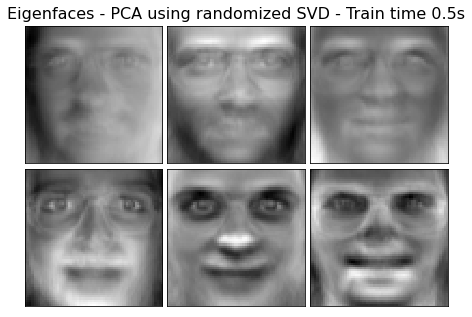

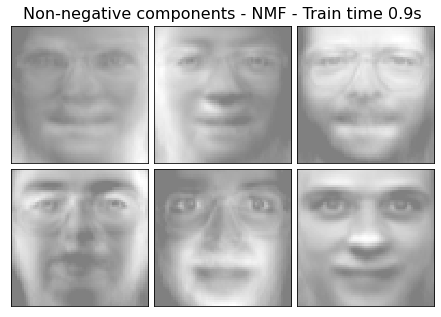

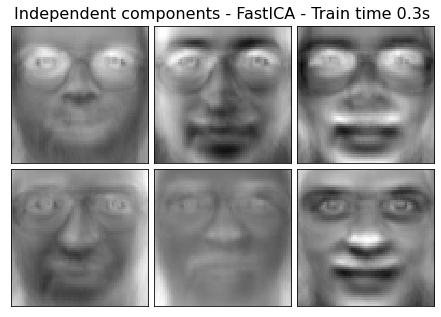

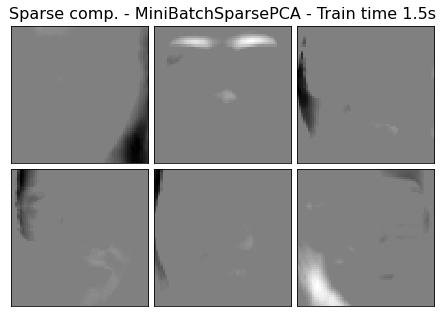

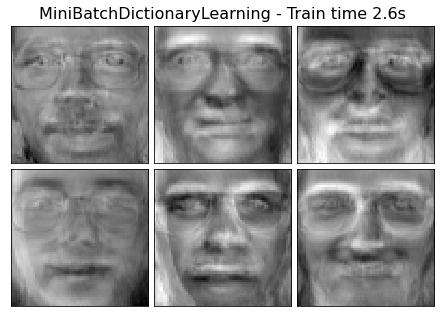

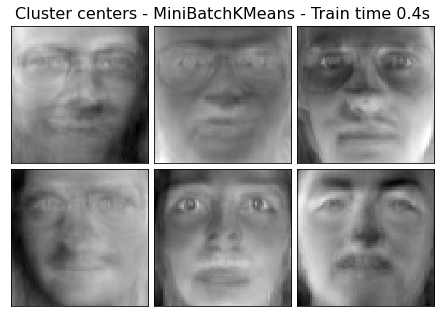

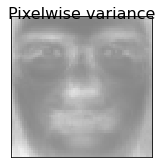

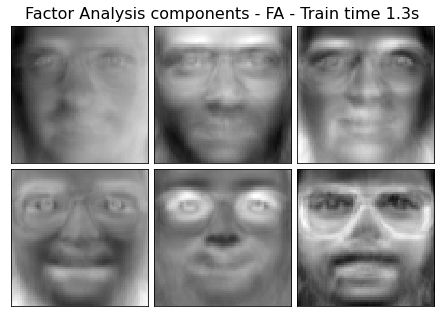

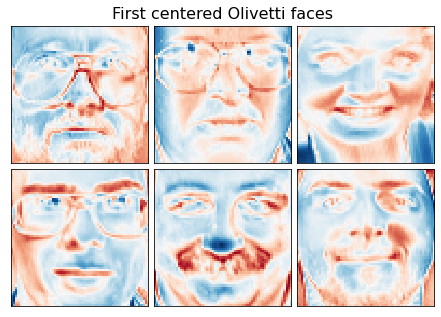

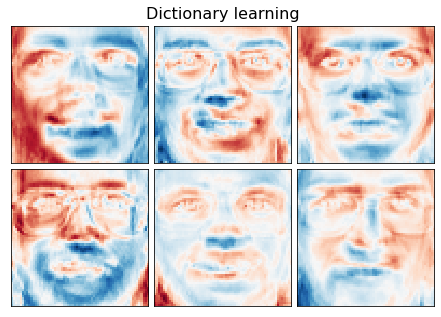

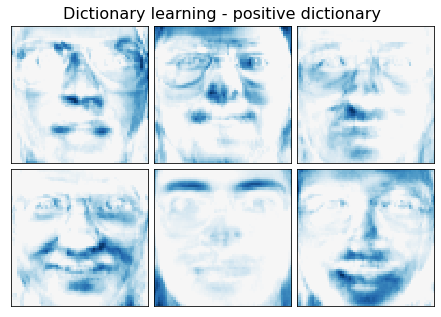

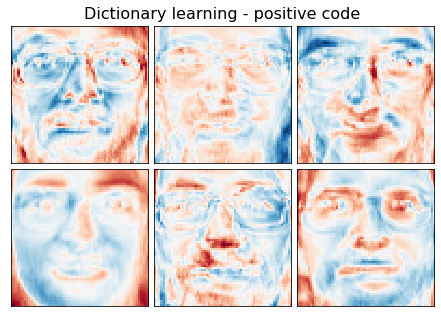

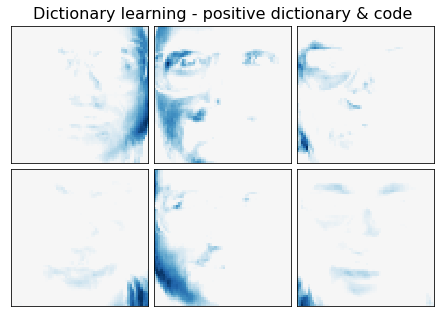

In [32]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=rng)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True), True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3), False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True), True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng), True),
    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng), True),
    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng), True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=20), True),]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it
for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1, n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time), components_[:n_components])
plt.show()

# #############################################################################
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    ('Dictionary learning - positive code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  fit_algorithm='cd',
                                                  random_state=rng,
                                                  positive_code=True),
     True),
    ('Dictionary learning - positive dictionary & code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  fit_algorithm='cd',
                                                  random_state=rng,
                                                  positive_dict=True,
                                                  positive_code=True),
     True),
]
# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components], cmap=plt.cm.RdBu)
# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], cmap=plt.cm.RdBu)

plt.show()

#### Kernel PCA
KernelPCA is an extension of PCA which achieves non-linear dimensionality reduction through the use of kernels (see Pairwise metrics, Affinities and Kernels). It has many applications including denoising, compression and structured prediction (kernel dependency estimation)

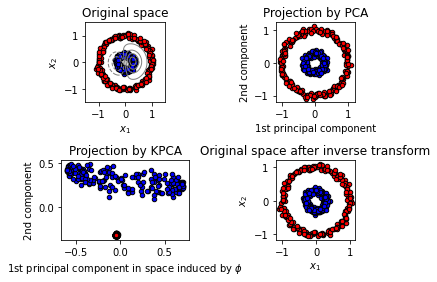

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue", s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

##### SparsePCA
SparsePCA is a variant of PCA, with the goal of extracting the set of sparse components that best reconstruct the data.
Principal component analysis (PCA) has the disadvantage that the components extracted by this method have exclusively dense expressions, i.e. they have non-zero coefficients when expressed as linear combinations of the original variables. This can make interpretation difficult.

#### Truncated singular value decomposition and latent semantic analysis
TruncatedSVD implements a variant of singular value decomposition (SVD) that only computes the largest singular values, where is a user-specified parameter.

When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality

In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa", dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch", action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf", action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing", action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000, help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose", action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = ['alt.atheism',
              'talk.religion.misc',
              'comp.graphics',
              'sci.space',]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False, norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features, stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english', use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

2021-02-21 06:57:22,898 INFO Downloading 20news dataset. This may take a few minutes.
2021-02-21 06:57:22,900 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 0.760625s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_siz

##### Sparse coding with a precomputed dictionary
Transform a signal as a sparse combination of Ricker wavelets. This example visually compares different sparse coding methods using the SparseCoder estimator.

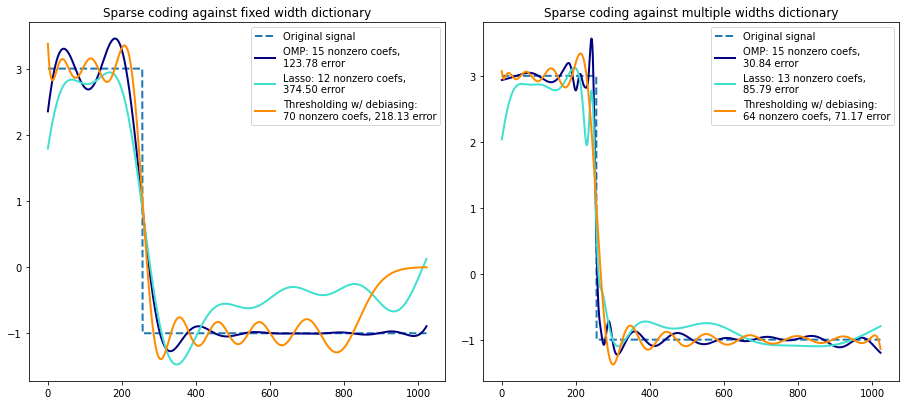

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparseCoder
from sklearn.utils.fixes import np_version, parse_version


def ricker_function(resolution, center, width):
    """Discrete sub-sampled Ricker (Mexican hat) wavelet"""
    x = np.linspace(0, resolution - 1, resolution)
    x = ((2 / (np.sqrt(3 * width) * np.pi ** .25))
         * (1 - (x - center) ** 2 / width ** 2)
         * np.exp(-(x - center) ** 2 / (2 * width ** 2)))
    return x


def ricker_matrix(width, resolution, n_components):
    """Dictionary of Ricker (Mexican hat) wavelets"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D ** 2, axis=1))[:, np.newaxis]
    return D


resolution = 1024
subsampling = 3  # subsampling factor
width = 100
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width=width, resolution=resolution, n_components=n_components)
D_multi = np.r_[tuple(ricker_matrix(width=w, resolution=resolution, n_components=n_components // 5)
                for w in (10, 50, 100, 500, 1000))]

# Generate a signal
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3.
y[np.logical_not(first_quarter)] = -1.

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [('OMP', 'omp', None, 15, 'navy'),
              ('Lasso', 'lasso_lars', 2, None, 'turquoise'), ]
lw = 2
# Avoid FutureWarning about default value change when numpy >= 1.14
lstsq_rcond = None if np_version >= parse_version('1.14') else -1

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(zip((D_fixed, D_multi),
                                         ('fixed width', 'multiple widths'))):
    plt.subplot(1, 2, subplot + 1)
    plt.title('Sparse coding against %s dictionary' % title)
    plt.plot(y, lw=lw, linestyle='--', label='Original signal')
    # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=n_nonzero,
                            transform_alpha=alpha, transform_algorithm=algo)
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(x, color=color, lw=lw,
                 label='%s: %s nonzero coefs,\n%.2f error'
                 % (title, density, squared_error))

    # Soft thresholding debiasing
    coder = SparseCoder(dictionary=D, transform_algorithm='threshold',
                        transform_alpha=20)
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=lstsq_rcond)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(x, color='darkorange', lw=lw,
             label='Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error'
             % (len(idx), squared_error))
    plt.axis('tight')
    plt.legend(shadow=False, loc='best')
plt.subplots_adjust(.04, .07, .97, .90, .09, .2)
plt.show()

 Dictionary learning (DictionaryLearning) is a matrix factorization problem that amounts to finding a (usually overcomplete) dictionary that will perform well at sparsely encoding the fitted data.

Representing data as sparse combinations of atoms from an overcomplete dictionary is suggested to be the way the mammalian primary visual cortex works. Consequently, dictionary learning applied on image patches has been shown to give good results in image processing tasks such as image completion, inpainting and denoising, as well as for supervised recognition tasks.

Distorting image...
Extracting reference patches...
done in 0.02s.
Learning the dictionary...
done in 14.03s.
Extracting noisy patches... 
done in 0.00s.
Orthogonal Matching Pursuit
1 atom...
done in 1.00s.
Orthogonal Matching Pursuit
2 atoms...
done in 2.05s.
Least-angle regression
5 atoms...
done in 18.12s.
Thresholding
 alpha=0.1...
done in 0.21s.


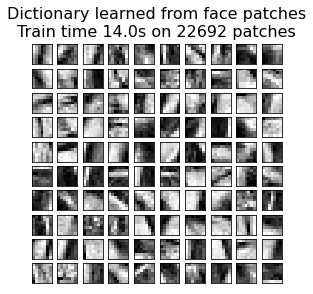

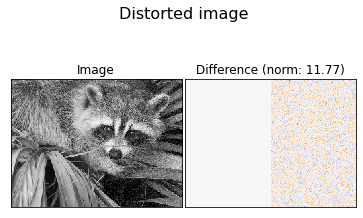

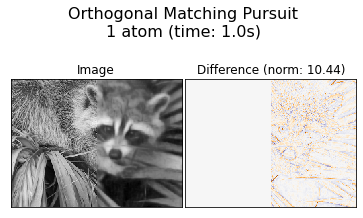

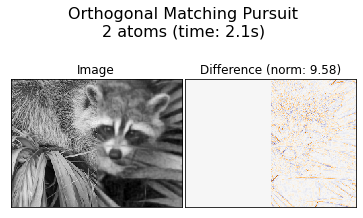

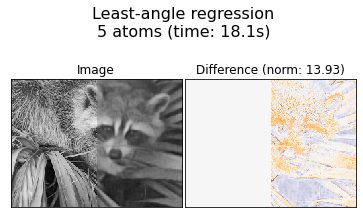

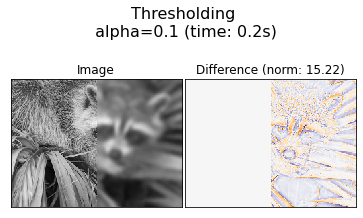

In [3]:
# Image denoising using dictionary learning

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)), fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face, title + ' (time: %.1fs)' % dt)

plt.show()

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 11 cluster centers.
Partial fit of  100 out of 2400
Partial fit of  200 out of 2400
Partial fit of  300 out of 2400
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partial fit of 2200 out of 2400
Partial fit of 2300 out of 2400
Partial fit of 2400 out of 2400
done in 13.24s.


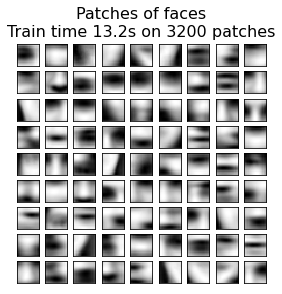

In [5]:
# Online learning of a dictionary of parts of faces
# This example uses a large dataset of faces to learn a set of 20 x 20 images patches that constitute faces.

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

faces = datasets.fetch_olivetti_faces()

# #############################################################################
# Learn the dictionary of images

print('Learning the dictionary... ')
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True)
patch_size = (20, 20)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print('Partial fit of %4i out of %i' % (index, 6 * len(faces.images)))

dt = time.time() - t0
print('done in %.2fs.' % dt)
# #############################################################################
# Plot the results
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

plt.suptitle('Patches of faces\nTrain time %.1fs on %d patches' %
             (dt, 8 * len(faces.images)), fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

#### Factor Analysis
FA can model variances in every direction of the input space independently.



 PCA :

[[ 0.52106591  0.37741762]
 [-0.26934744  0.92329566]
 [ 0.5804131   0.02449161]
 [ 0.56485654  0.06694199]]


 Unrotated FA :

[[ 0.88096009 -0.4472869 ]
 [-0.41691605 -0.55390036]
 [ 0.99918858  0.01915283]
 [ 0.96228895  0.05840206]]


 Varimax FA :

[[ 0.98633022 -0.05752333]
 [-0.16052385 -0.67443065]
 [ 0.90809432  0.41726413]
 [ 0.85857475  0.43847489]]


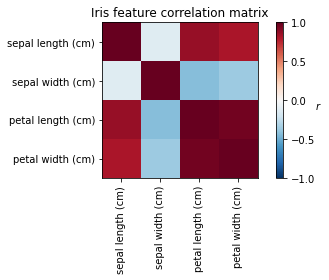

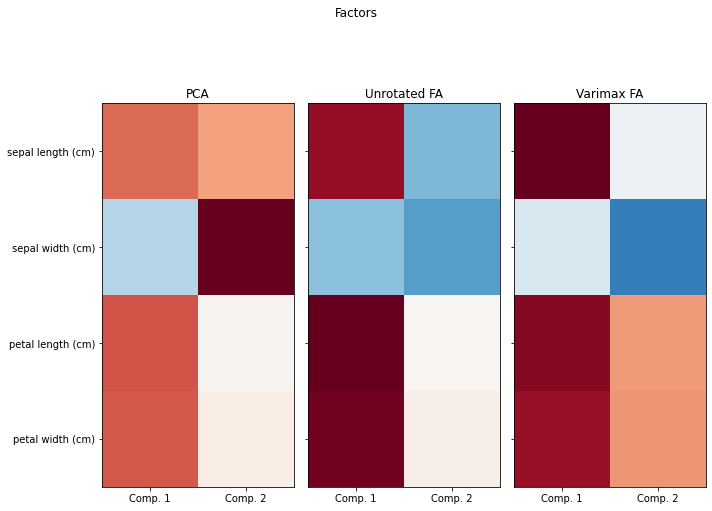

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
data = load_iris()
X = StandardScaler().fit_transform(data["data"])
feature_names = data["feature_names"]

ax = plt.axes()

im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(list(feature_names), rotation=90)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Iris feature correlation matrix")
plt.tight_layout()

n_comps = 2
methods = [('PCA', PCA()),
           ('Unrotated FA', FactorAnalysis()),
           ('Varimax FA', FactorAnalysis(rotation='varimax'))]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    print(components)

    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Comp. 1", "Comp. 2"])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

#### Independent Component Analysis
Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is classically used to separate mixed signals (a problem known as blind source separation).

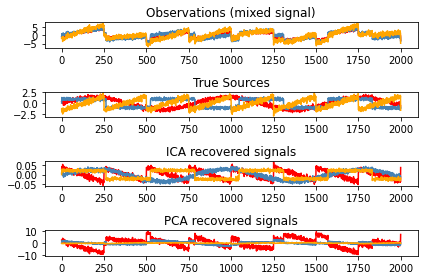

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

#### FastICA on 2D point clouds

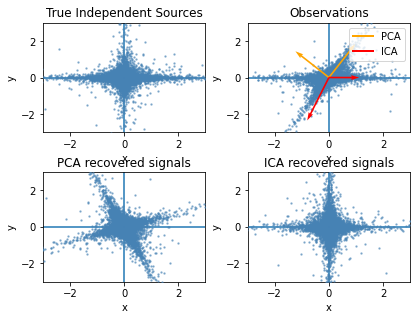

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA

# #############################################################################
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)


# #############################################################################
# Plot results

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01,
                       scale=6, color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()


#### Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying NMF and LatentDirichletAllocation on a corpus of documents and extract additive models of the topic structure of the corpus. The output is a plot of topics, each represented as bar plot using top few words based on weights.

Loading dataset...
done in 1.675s.
Extracting tf-idf features for NMF...
done in 0.554s.
Extracting tf features for LDA...
done in 0.512s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.720s.


 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 1.695s.


 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 4.294s.


/home/sod/PycharmProjects/scientific_python/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/sod/PycharmProjects/scientific_python/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


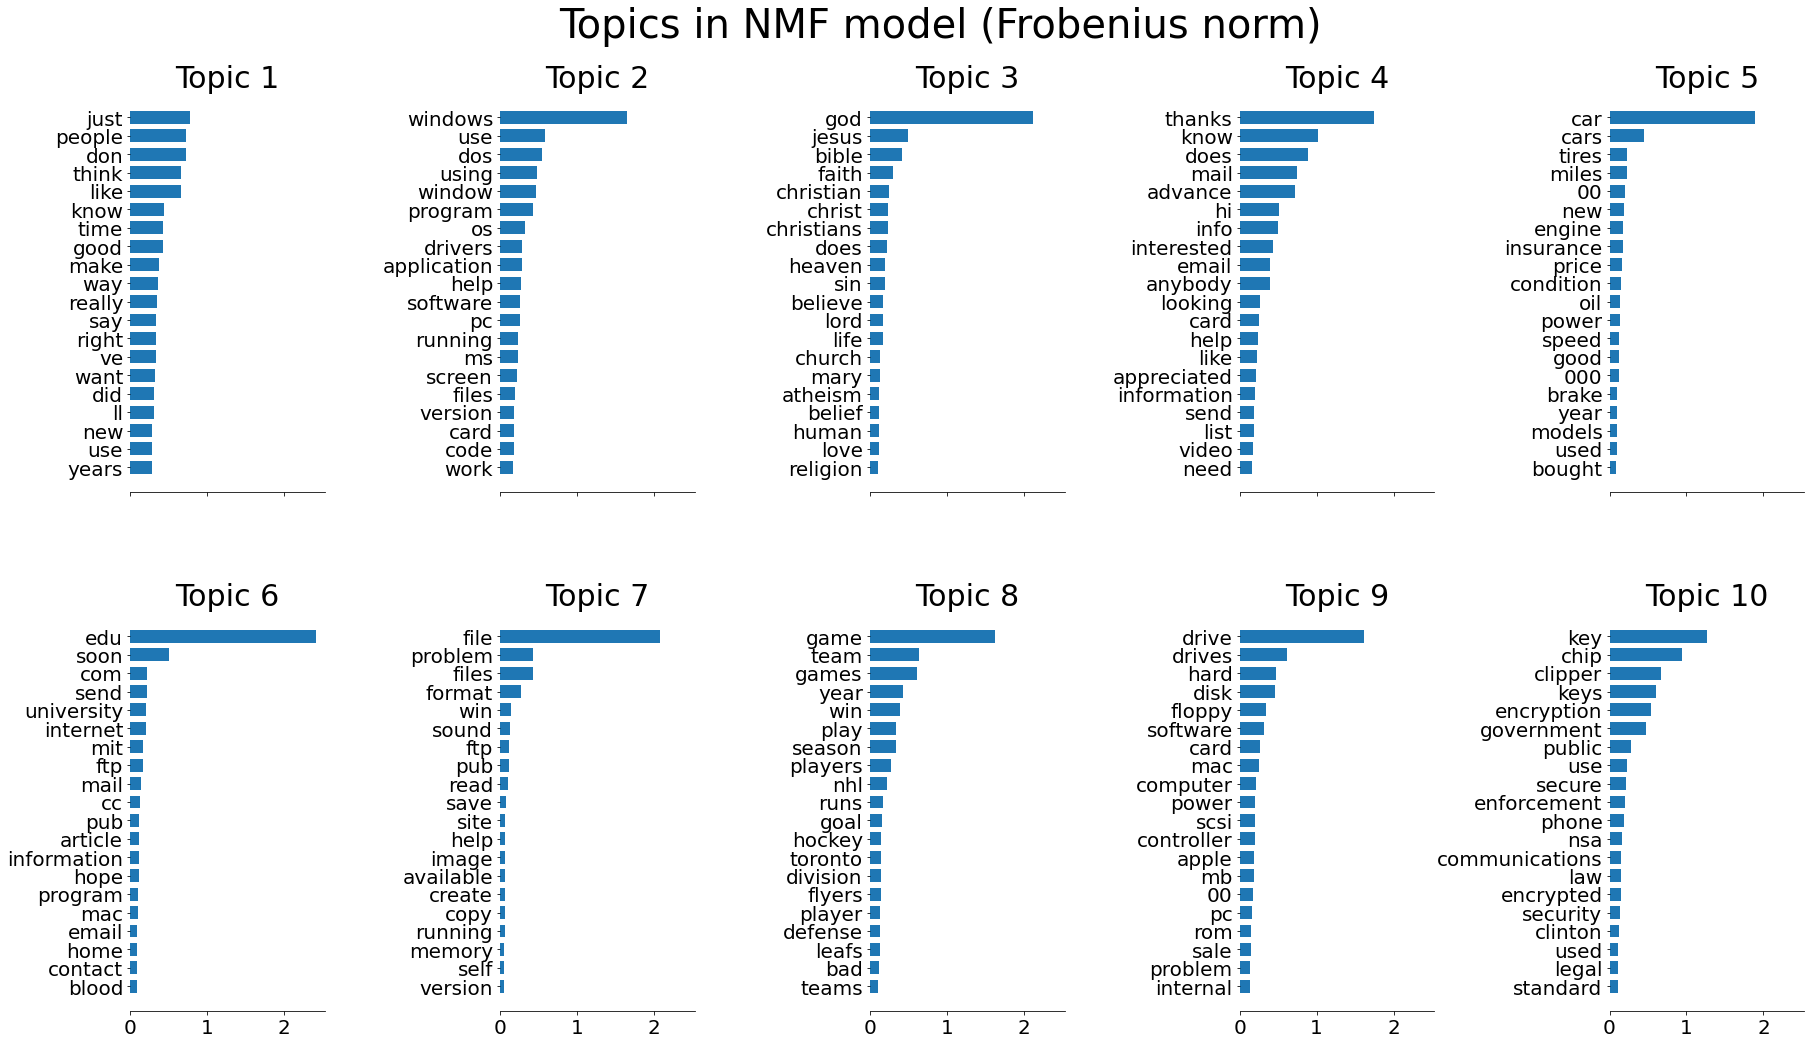

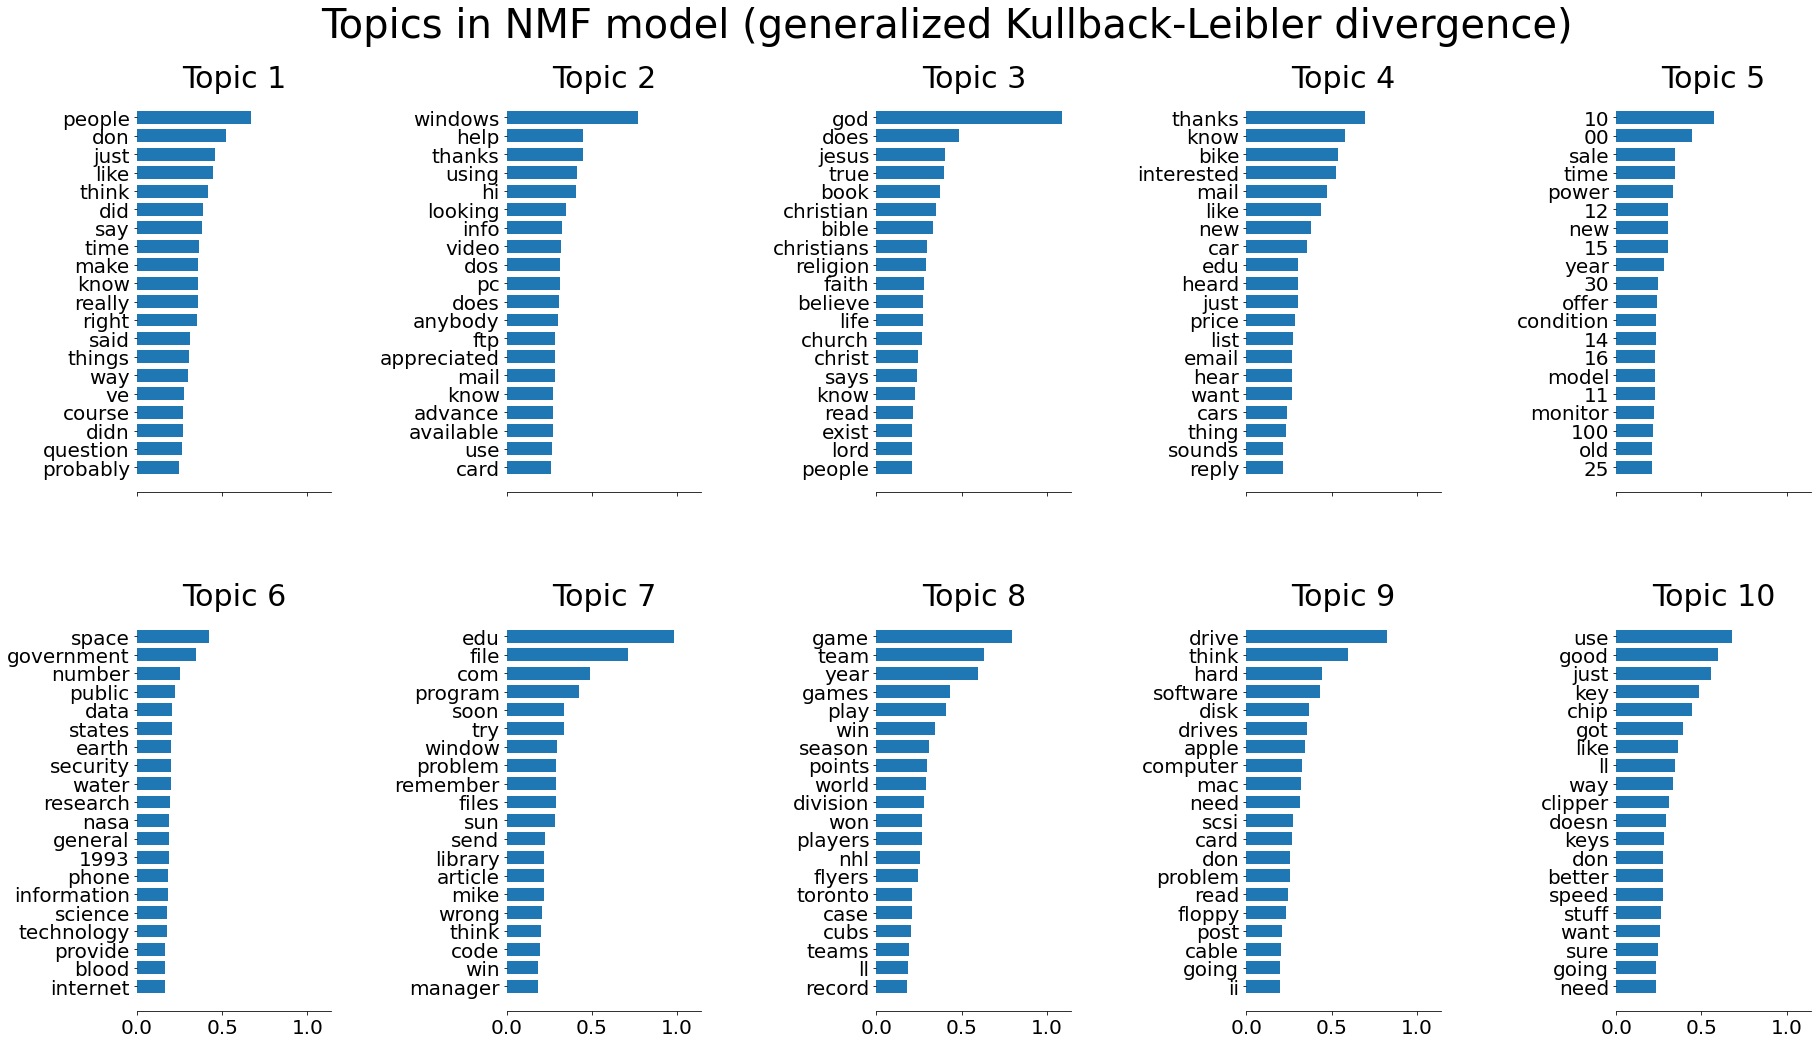

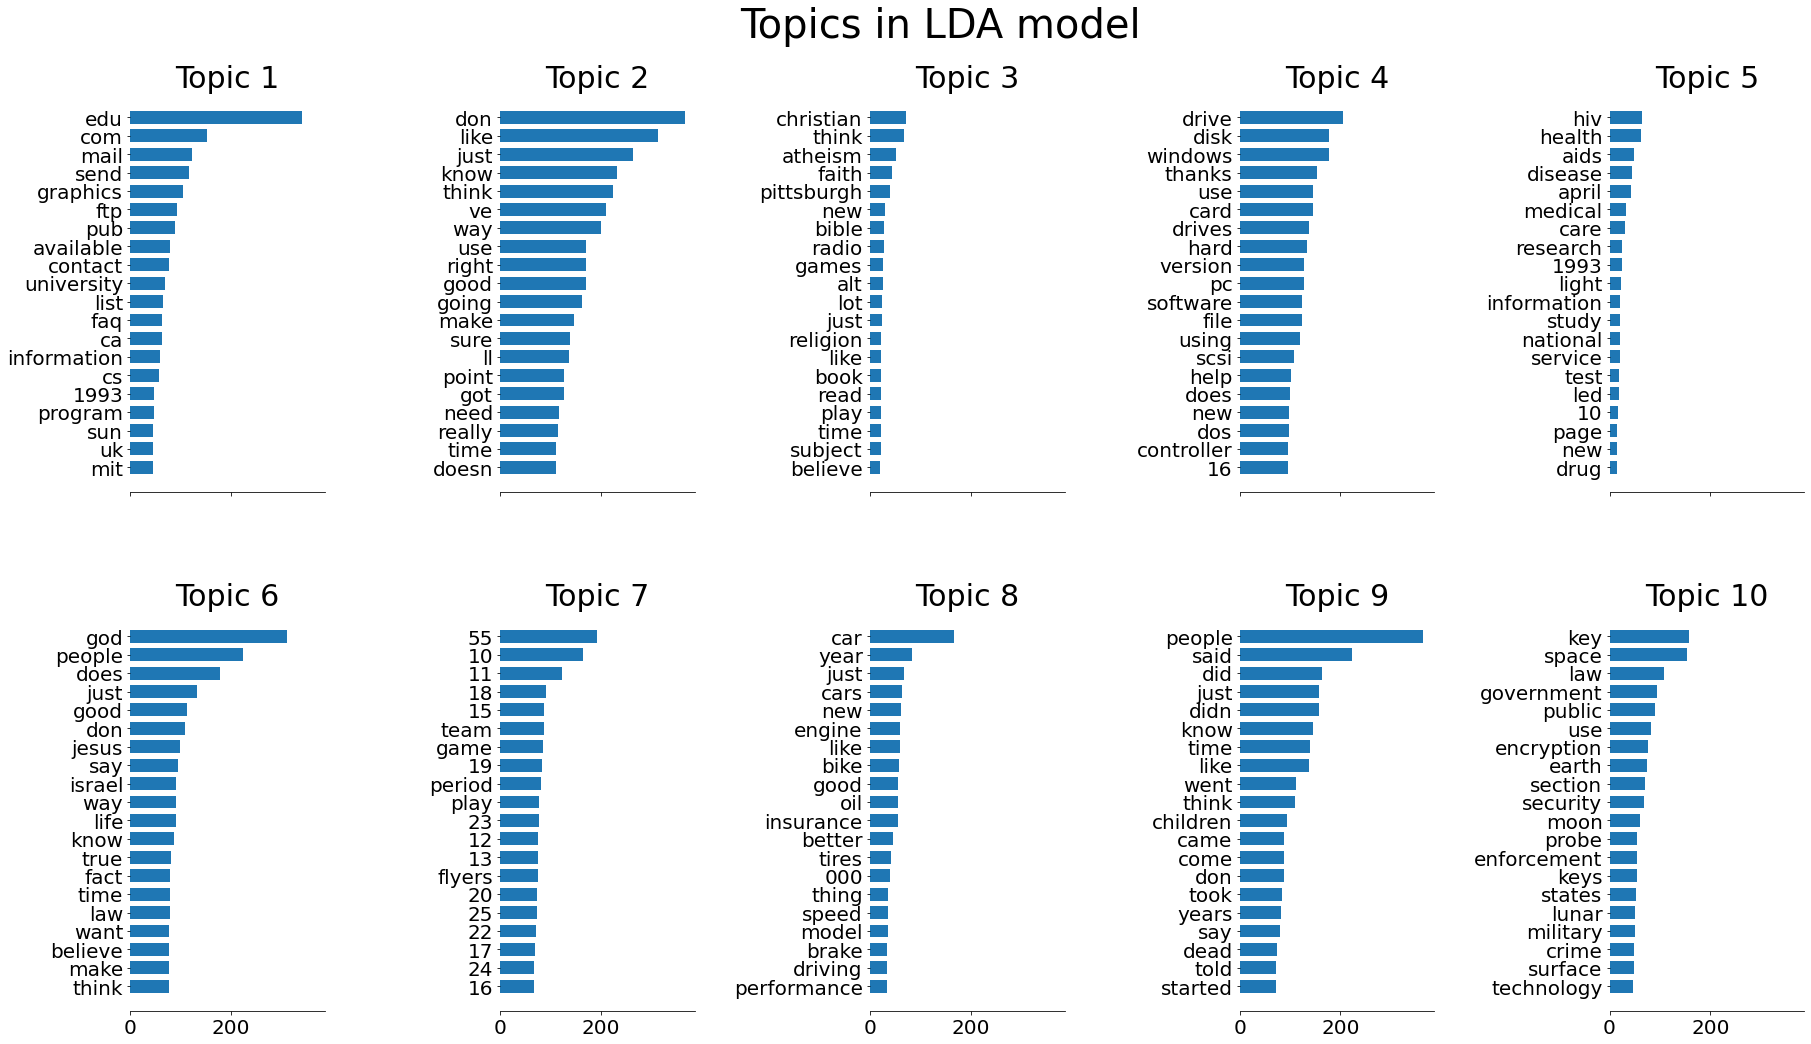

In [12]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [13]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
X_new = np.array([[1, 0], [1, 6.1], [1, 0], [1, 4], [3.2, 1], [0, 4]])
W_new = model.transform(X_new)


Automatically created module for IPython interactive environment


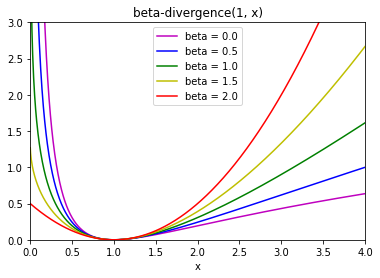

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition._nmf import _beta_divergence

print(__doc__)

x = np.linspace(0.001, 4, 1000)
y = np.zeros(x.shape)

colors = 'mbgyr'
for j, beta in enumerate((0., 0.5, 1., 1.5, 2.)):
    for i, xi in enumerate(x):
        y[i] = _beta_divergence(1, xi, 1, beta)
    name = "beta = %1.1f" % beta
    plt.plot(x, y, label=name, color=colors[j])

plt.xlabel("x")
plt.title("beta-divergence(1, x)")
plt.legend(loc=0)
plt.axis([0, 4, 0, 3])
plt.show()